In [2]:
import sys
import ast
import json
from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer
import sys
import pickle
from rouge_score import rouge_scorer
from rouge_score import scoring
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import ttest_ind

## Baseline: Longformer2Roberta trained on 40k standard pubmed documents

In [4]:
pubmed_results_df = pd.read_csv('../results/pre_trained_pubmed/summaries_test_model1.csv')
pubmed_results_df.head()

,Unnamed: 0,abstract,article,pred_new,section_names
0,0,research on the implications of anxiety in pa...,anxiety affects quality of life in those livin...,objectiveto investigate the effects of anxiet...,1. Introduction\n2. Methods\n3. Results\n4. Di...
1,1,"small non - coding rnas include sirna , mirna...",small non - coding rnas are transcribed into m...,"mir-17/22/16, a novel gene that regulates the...",Introduction\nAberrant Expression of miRNA in ...
2,2,objective : to evaluate the efficacy and safe...,ohss is a serious complication of ovulation in...,\n objective. to evaluate the role of pigtail...,Introduction\nMaterials and Methods\nResults\n...
3,3,congenital adrenal hyperplasia is a group of ...,congenital adrenal hyperplasia ( cah ) refers ...,objective : to report the clinical presentati...,I\nM\nR\nD
4,4,objective(s):pentoxifylline is an immunomodul...,type 1 diabetes ( t1d ) results from the destr...,the present study aimed to investigate the im...,Introduction\nMaterials and Methods\nDrug and ...


In [5]:
# rank summaries
r1 = []
r2 = []
rlsum = []
# initialize scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeLsum"], use_stemmer=True)
# iterate and score each document
for i in range(len(pubmed_results_df)):
    pred = pubmed_results_df.pred_new[i]
    ref = pubmed_results_df.abstract[i]
    score = scorer.score(ref, pred)
    r1.append(score['rouge1'].fmeasure)
    r2.append(score['rouge2'].fmeasure)
    rlsum.append(score['rougeLsum'].fmeasure)
# add scores to dataframe
pubmed_results_df['r1'] = r1
pubmed_results_df['r2'] = r2
pubmed_results_df['rlsum'] = rlsum

In [6]:
pubmed_results_df.describe()

,Unnamed: 0,r1,r2,rlsum
count,6658.000000,6658.000000,6658.000000,6658.000000
mean,3328.500000,0.292444,0.081956,0.264025
std,1922.143378,0.071614,0.046239,0.064865
min,0.000000,0.000000,0.000000,0.000000
25%,1664.250000,0.243655,0.049055,0.219330
50%,3328.500000,0.292023,0.076023,0.262295
75%,4992.750000,0.339838,0.108108,0.307242
max,6657.000000,0.566667,0.368932,0.537445


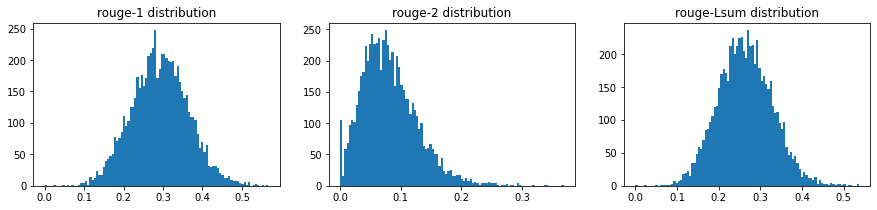

In [7]:
# plot distributions for each metric
fig, ax = plt.subplots(1,3,figsize=(15,3))
ax[0].hist(pubmed_results_df['r1'], bins=100)
ax[0].set_title('rouge-1 distribution')
ax[1].hist(pubmed_results_df['r2'], bins=100)
ax[1].set_title('rouge-2 distribution')
ax[2].hist(pubmed_results_df['rlsum'], bins=100)
ax[2].set_title('rouge-Lsum distribution')
pass

## Experiment 1: Longformer2Roberta trained on 40k pubmed documents, evaluated on ranked data

In [14]:
ranked_pubmed_results_df = pd.read_csv('../results/summaries_rank_test_model1.csv')
ranked_pubmed_results_df.head()

,Unnamed: 0,__index_level_0__,pred_new,target,text
0,0,0,anxiety and cognitive impairment are associat...,<S> research on the implications of anxiety in...,self - reported hads was used to assess anxiet...
1,1,1,mirna expression is a major regulatory factor...,"<S> small non - coding rnas include sirna , mi...",although the tendency for a global decrease of...
2,2,2,the aim of this study was to describe the mod...,<S> objective : to evaluate the efficacy and s...,patients with critical ohss and those with per...
3,3,3,objective : to report the phenotypic features...,<S> congenital adrenal hyperplasia is a group ...,short stature was seen in one third of patient...
4,4,4,the present work demonstrated that the suppre...,<S> objective(s):pentoxifylline is an immunomo...,all stz - induced diabetic mice with ptx treat...


In [15]:
# rank summaries
r1 = []
r2 = []
rlsum = []
# initialize scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeLsum"], use_stemmer=True)
# iterate and score each document
for i in range(len(ranked_pubmed_results_df)):
    pred = ranked_pubmed_results_df.pred_new[i]
    ref = ranked_pubmed_results_df.target[i]
    score = scorer.score(ref, pred)
    r1.append(score['rouge1'].fmeasure)
    r2.append(score['rouge2'].fmeasure)
    rlsum.append(score['rougeLsum'].fmeasure)
# add scores to dataframe
ranked_pubmed_results_df['r1'] = r1
ranked_pubmed_results_df['r2'] = r2
ranked_pubmed_results_df['rlsum'] = rlsum

In [16]:
ranked_pubmed_results_df.describe()

,Unnamed: 0,__index_level_0__,r1,r2,rlsum
count,6658.000000,6658.000000,6658.000000,6658.000000,6658.000000
mean,3328.500000,3328.500000,0.284336,0.080275,0.195655
std,1922.143378,1922.143378,0.069776,0.044982,0.051091
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1664.250000,1664.250000,0.237553,0.047861,0.161435
50%,3328.500000,3328.500000,0.285714,0.074866,0.192104
75%,4992.750000,4992.750000,0.331754,0.106091,0.224404
max,6657.000000,6657.000000,0.581040,0.467692,0.529915


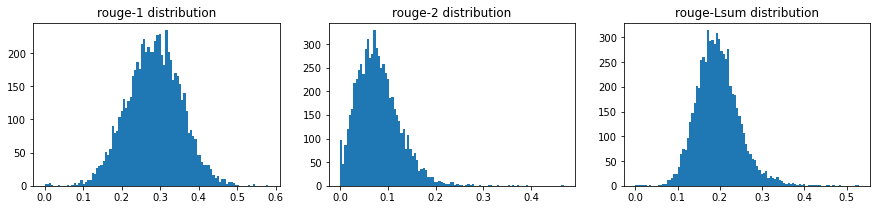

In [17]:
# plot distributions for each metric
fig, ax = plt.subplots(1,3,figsize=(15,3))
ax[0].hist(ranked_pubmed_results_df['r1'], bins=100)
ax[0].set_title('rouge-1 distribution')
ax[1].hist(ranked_pubmed_results_df['r2'], bins=100)
ax[1].set_title('rouge-2 distribution')
ax[2].hist(ranked_pubmed_results_df['rlsum'], bins=100)
ax[2].set_title('rouge-Lsum distribution')
pass

## Experiment 2: Longformer2Roberta trained on 40k ranked and temporally corrected pubmed documents

In [18]:
ranked_temporal_pubmed_results_df = pd.read_csv('../results/summaries_temporal_ranked_test_model1.csv')
ranked_temporal_pubmed_results_df.head()

,Unnamed: 0,__index_level_0__,pred_new,target,text
0,0,0,objectiveto investigate the relationship betw...,<S> research on the implications of anxiety in...,anxiety affects quality of life in those livin...
1,1,1,mirna regulates the cell cycle through the re...,"<S> small non - coding rnas include sirna , mi...",small non - coding rnas are transcribed into m...
2,2,2,\n objective. to evaluate the efficacy and sa...,<S> objective : to evaluate the efficacy and s...,ohss is a serious complication of ovulation in...
3,3,3,the aim of this series was to report the clin...,<S> congenital adrenal hyperplasia is a group ...,congenital adrenal hyperplasia ( cah ) refers ...
4,4,4,the present study investigated whether pentox...,<S> objective(s):pentoxifylline is an immunomo...,type 1 diabetes ( t1d ) results from the destr...


In [19]:
# rank summaries
r1 = []
r2 = []
rlsum = []
# initialize scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeLsum"], use_stemmer=True)
# iterate and score each document
for i in range(len(ranked_temporal_pubmed_results_df)):
    pred = ranked_temporal_pubmed_results_df.pred_new[i]
    ref = ranked_temporal_pubmed_results_df.target[i]
    score = scorer.score(ref, pred)
    r1.append(score['rouge1'].fmeasure)
    r2.append(score['rouge2'].fmeasure)
    rlsum.append(score['rougeLsum'].fmeasure)
# add scores to dataframe
ranked_temporal_pubmed_results_df['r1'] = r1
ranked_temporal_pubmed_results_df['r2'] = r2
ranked_temporal_pubmed_results_df['rlsum'] = rlsum

In [20]:
ranked_temporal_pubmed_results_df.describe()

,Unnamed: 0,__index_level_0__,r1,r2,rlsum
count,6658.000000,6658.000000,6658.000000,6658.000000,6658.000000
mean,3328.500000,3328.500000,0.284661,0.079792,0.195197
std,1922.143378,1922.143378,0.070352,0.044787,0.051646
min,0.000000,0.000000,0.006969,0.000000,0.006969
25%,1664.250000,1664.250000,0.238125,0.047880,0.161386
50%,3328.500000,3328.500000,0.286472,0.074324,0.190955
75%,4992.750000,4992.750000,0.331240,0.104697,0.224215
max,6657.000000,6657.000000,0.555556,0.373494,0.477778


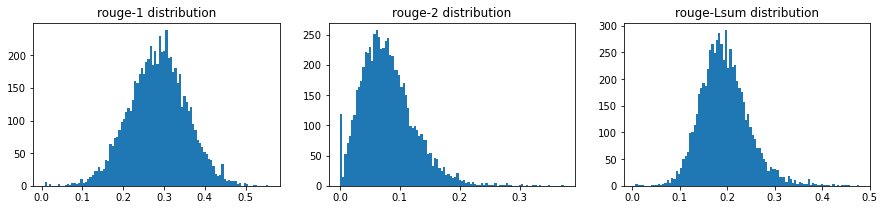

In [21]:
# plot distributions for each metric
fig, ax = plt.subplots(1,3,figsize=(15,3))
ax[0].hist(ranked_temporal_pubmed_results_df['r1'], bins=100)
ax[0].set_title('rouge-1 distribution')
ax[1].hist(ranked_temporal_pubmed_results_df['r2'], bins=100)
ax[1].set_title('rouge-2 distribution')
ax[2].hist(ranked_temporal_pubmed_results_df['rlsum'], bins=100)
ax[2].set_title('rouge-Lsum distribution')
pass

## Generate Lengths

In [22]:
# Import test data
with open('../data/json_test.txt') as json_file:
    test = json.load(json_file)
test = test['data']

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096", add_prefix_space=True)
doc_len = []
for i in test:
    input_ = i['article_text']
    length = len(tokenizer(input_, is_split_into_words=True, return_tensors='pt', truncation=False)[0])
    doc_len.append(length)

pubmed_results_df['doc_len'] = doc_len
ranked_pubmed_results_df['doc_len'] = doc_len
ranked_temporal_pubmed_results_df['doc_len'] = doc_len

Token indices sequence length is longer than the specified maximum sequence length for this model (4604 > 4096). Running this sequence through the model will result in indexing errors


## Statistical tests, and distribution overlay (ranked vs original)

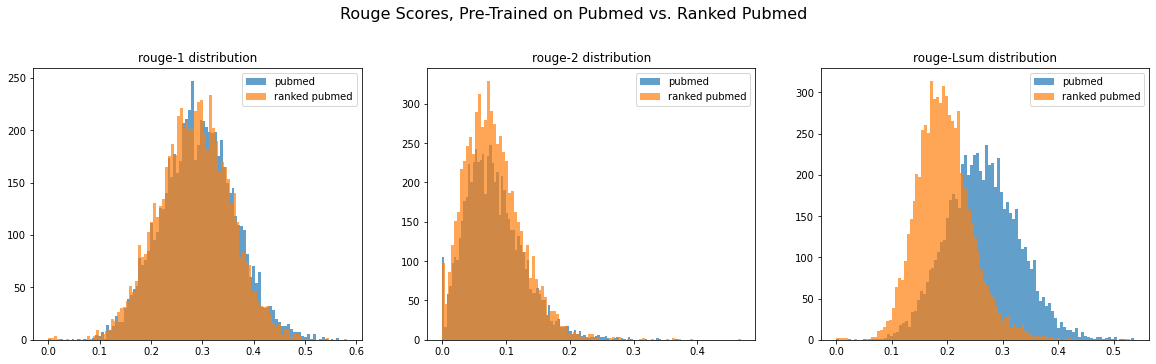

In [23]:
# plot distributions for each metric
fig, ax = plt.subplots(1,3,figsize=(20,5))
kwargs = {'alpha':0.7, 'bins':100}
ax[0].hist(pubmed_results_df['r1'], **kwargs, label='pubmed')
ax[0].hist(ranked_pubmed_results_df['r1'], **kwargs, label='ranked pubmed')
ax[0].legend()
ax[0].set_title('rouge-1 distribution')
ax[1].hist(pubmed_results_df['r2'], **kwargs, label='pubmed')
ax[1].hist(ranked_pubmed_results_df['r2'], **kwargs, label='ranked pubmed')
ax[1].set_title('rouge-2 distribution')
ax[1].legend()
ax[2].hist(pubmed_results_df['rlsum'], **kwargs, label='pubmed')
ax[2].hist(ranked_pubmed_results_df['rlsum'], **kwargs, label='ranked pubmed')
ax[2].set_title('rouge-Lsum distribution')
ax[2].legend()
plt.suptitle('Rouge Scores, Pre-Trained on Pubmed vs. Ranked Pubmed', y=1.05, size=16)
pass

In [24]:
# t-tests
print('overall:')
df1 = pubmed_results_df
df2 = ranked_pubmed_results_df
r1_pubmed = df1['r1']
r1_ranked = df2['r1']
r1_t_test = ttest_ind(r1_pubmed, r1_ranked, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-1 t-test:\n{r1_t_test}')
print('----')
r2_pubmed = df1['r2']
r2_ranked = df2['r2']
r2_t_test = ttest_ind(r2_pubmed, r2_ranked, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-2 t-test:\n{r2_t_test}')
print('----')
rl_pubmed = df1['rlsum']
rl_ranked = df2['rlsum']
rl_t_test = ttest_ind(rl_pubmed, rl_ranked, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-Lsum t-test:\n{rl_t_test}')
print('\n')

# long documents
print('documents > 4096 tokens:')
df1 = pubmed_results_df[pubmed_results_df['doc_len'] > 4096]
df2 = ranked_pubmed_results_df[ranked_pubmed_results_df['doc_len'] > 4096]
r1_pubmed = df1['r1']
r1_ranked = df2['r1']
r1_t_test = ttest_ind(r1_pubmed, r1_ranked, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-1 t-test:\n{r1_t_test}')
print('----')
r2_pubmed = df1['r2']
r2_ranked = df2['r2']
r2_t_test = ttest_ind(r2_pubmed, r2_ranked, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-2 t-test:\n{r2_t_test}')
print('----')
rl_pubmed = df1['rlsum']
rl_ranked = df2['rlsum']
rl_t_test = ttest_ind(rl_pubmed, rl_ranked, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-Lsum t-test:\n{rl_t_test}')
print('\n')

# short documents
print('documents < 4096 tokens:')
df1 = pubmed_results_df[pubmed_results_df['doc_len'] < 4096]
df2 = ranked_pubmed_results_df[ranked_pubmed_results_df['doc_len'] < 4096]
r1_pubmed = df1['r1']
r1_ranked = df2['r1']
r1_t_test = ttest_ind(r1_pubmed, r1_ranked, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-1 t-test:\n{r1_t_test}')
print('----')
r2_pubmed = df1['r2']
r2_ranked = df2['r2']
r2_t_test = ttest_ind(r2_pubmed, r2_ranked, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-2 t-test:\n{r2_t_test}')
print('----')
rl_pubmed = df1['rlsum']
rl_ranked = df2['rlsum']
rl_t_test = ttest_ind(rl_pubmed, rl_ranked, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-Lsum t-test:\n{rl_t_test}')
print('\n')
print(len(df1))
print(len(df2))

overall:
Results for Rouge-1 t-test:
Ttest_indResult(statistic=6.616846143999712, pvalue=3.809900935783315e-11)
----
Results for Rouge-2 t-test:
Ttest_indResult(statistic=2.126572358856952, pvalue=0.0334739847893505)
----
Results for Rouge-Lsum t-test:
Ttest_indResult(statistic=67.56488845783451, pvalue=0.0)


documents > 4096 tokens:
Results for Rouge-1 t-test:
Ttest_indResult(statistic=0.4142912275511362, pvalue=0.6786798288086889)
----
Results for Rouge-2 t-test:
Ttest_indResult(statistic=-3.4865499578616377, pvalue=0.0004937912898243798)
----
Results for Rouge-Lsum t-test:
Ttest_indResult(statistic=38.43564524454889, pvalue=3.1487834915694343e-279)


documents < 4096 tokens:
Results for Rouge-1 t-test:
Ttest_indResult(statistic=7.907148563115737, pvalue=2.958664147092466e-15)
----
Results for Rouge-2 t-test:
Ttest_indResult(statistic=4.677530948620558, pvalue=2.947686272741333e-06)
----
Results for Rouge-Lsum t-test:
Ttest_indResult(statistic=56.19259503268883, pvalue=0.0)


4316
4

## Statistical tests, and distribution overlay (ranked and temporally aligned vs original)

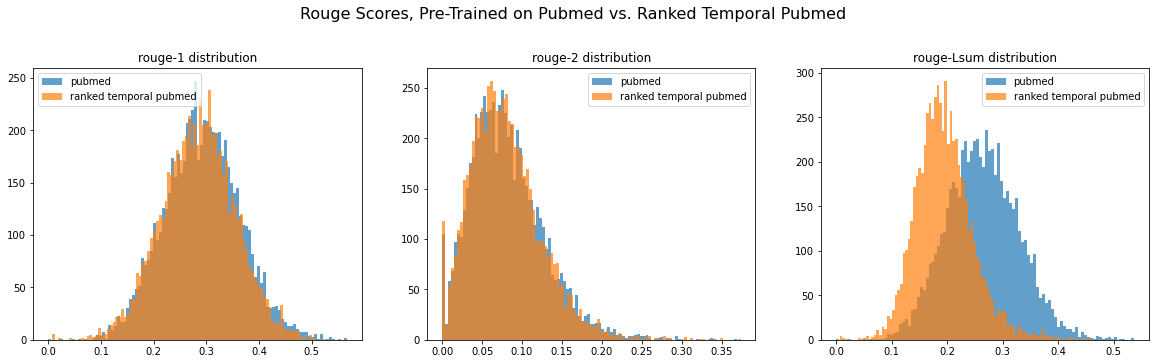

In [25]:
# plot distributions for each metric
fig, ax = plt.subplots(1,3,figsize=(20,5))
kwargs = {'alpha':0.7, 'bins':100}
ax[0].hist(pubmed_results_df['r1'], **kwargs, label='pubmed')
ax[0].hist(ranked_temporal_pubmed_results_df['r1'], **kwargs, label='ranked temporal pubmed')
ax[0].legend()
ax[0].set_title('rouge-1 distribution')
ax[1].hist(pubmed_results_df['r2'], **kwargs, label='pubmed')
ax[1].hist(ranked_temporal_pubmed_results_df['r2'], **kwargs, label='ranked temporal pubmed')
ax[1].set_title('rouge-2 distribution')
ax[1].legend()
ax[2].hist(pubmed_results_df['rlsum'], **kwargs, label='pubmed')
ax[2].hist(ranked_temporal_pubmed_results_df['rlsum'], **kwargs, label='ranked temporal pubmed')
ax[2].set_title('rouge-Lsum distribution')
ax[2].legend()
plt.suptitle('Rouge Scores, Pre-Trained on Pubmed vs. Ranked Temporal Pubmed', y=1.05, size=16)
pass

In [26]:
# t-tests
print('overall:')
df1 = pubmed_results_df
df2 = ranked_temporal_pubmed_results_df
r1_pubmed = df1['r1']
r1_ranked_temporal = df2['r1']
r1_t_test = ttest_ind(r1_pubmed, r1_ranked_temporal, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-1 t-test:\n{r1_t_test}')
print('----')
r2_pubmed = df1['r2']
r2_ranked_temporal = df2['r2']
r2_t_test = ttest_ind(r2_pubmed, r2_ranked_temporal, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-2 t-test:\n{r2_t_test}')
print('----')
rl_pubmed = df1['rlsum']
rl_ranked_temporal = df2['rlsum']
rl_t_test = ttest_ind(rl_pubmed, rl_ranked_temporal, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-Lsum t-test:\n{rl_t_test}')
print('\n')

# long documents
print('documents > 4096 tokens:')
df1 = pubmed_results_df[pubmed_results_df['doc_len'] > 4096]
df2 = ranked_temporal_pubmed_results_df[ranked_temporal_pubmed_results_df['doc_len'] > 4096]
r1_pubmed = df1['r1']
r1_ranked_temporal = df2['r1']
r1_t_test = ttest_ind(r1_pubmed, r1_ranked_temporal, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-1 t-test:\n{r1_t_test}')
print('----')
r2_pubmed = df1['r2']
r2_ranked_temporal = df2['r2']
r2_t_test = ttest_ind(r2_pubmed, r2_ranked_temporal, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-2 t-test:\n{r2_t_test}')
print('----')
rl_pubmed = df1['rlsum']
rl_ranked_temporal = df2['rlsum']
rl_t_test = ttest_ind(rl_pubmed, rl_ranked_temporal, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-Lsum t-test:\n{rl_t_test}')
print('\n')

# short documents
print('documents < 4096 tokens:')
df1 = pubmed_results_df[pubmed_results_df['doc_len'] < 4096]
df2 = ranked_temporal_pubmed_results_df[ranked_temporal_pubmed_results_df['doc_len'] < 4096]
r1_pubmed = df1['r1']
r1_ranked_temporal = df2['r1']
r1_t_test = ttest_ind(r1_pubmed, r1_ranked_temporal, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-1 t-test:\n{r1_t_test}')
print('----')
r2_pubmed = df1['r2']
r2_ranked_temporal = df2['r2']
r2_t_test = ttest_ind(r2_pubmed, r2_ranked_temporal, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-2 t-test:\n{r2_t_test}')
print('----')
rl_pubmed = df1['rlsum']
rl_ranked_temporal = df2['rlsum']
rl_t_test = ttest_ind(rl_pubmed, rl_ranked_temporal, equal_var=False, alternative='two-sided')
print(f'Results for Rouge-Lsum t-test:\n{rl_t_test}')
print('\n')
print(len(df1))
print(len(df2))

overall:
Results for Rouge-1 t-test:
Ttest_indResult(statistic=6.326044292192908, pvalue=2.5957654795137056e-10)
----
Results for Rouge-2 t-test:
Ttest_indResult(statistic=2.7436878315088196, pvalue=0.006083468995360057)
----
Results for Rouge-Lsum t-test:
Ttest_indResult(statistic=67.73464021488047, pvalue=0.0)


documents > 4096 tokens:
Results for Rouge-1 t-test:
Ttest_indResult(statistic=2.6129593340321233, pvalue=0.009004943480459672)
----
Results for Rouge-2 t-test:
Ttest_indResult(statistic=-0.05495515299667451, pvalue=0.9561765386592208)
----
Results for Rouge-Lsum t-test:
Ttest_indResult(statistic=40.546993226752996, pvalue=3.202333617255317e-306)


documents < 4096 tokens:
Results for Rouge-1 t-test:
Ttest_indResult(statistic=5.982228151414924, pvalue=2.288831638904959e-09)
----
Results for Rouge-2 t-test:
Ttest_indResult(statistic=3.2598416676528954, pvalue=0.0011190688350756442)
----
Results for Rouge-Lsum t-test:
Ttest_indResult(statistic=55.11224028642004, pvalue=0.0)


4

## Evaluation of performance with resepect to document length

In [27]:
# Import test data
with open('../data/json_test.txt') as json_file:
    test = json.load(json_file)
test = test['data']

In [28]:
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096", add_prefix_space=True)
doc_len = []
for i in test:
    input_ = i['article_text']
    length = len(tokenizer(input_, is_split_into_words=True, return_tensors='pt', truncation=False)[0])
    doc_len.append(length)

Token indices sequence length is longer than the specified maximum sequence length for this model (4604 > 4096). Running this sequence through the model will result in indexing errors


In [29]:
pubmed_results_df['doc_len'] = doc_len
ranked_pubmed_results_df['doc_len'] = doc_len
ranked_temporal_pubmed_results_df['doc_len'] = doc_len

r1 coefficient: -3.343158252369734e-06
r2 coefficient: -2.0722073712222936e-06
rlsum coefficient: -2.8078987838828495e-06

r1 Mean: 0.2924441052368615
r2 Mean: 0.0819560900711394
rlsum Mean: 0.26402545872119126


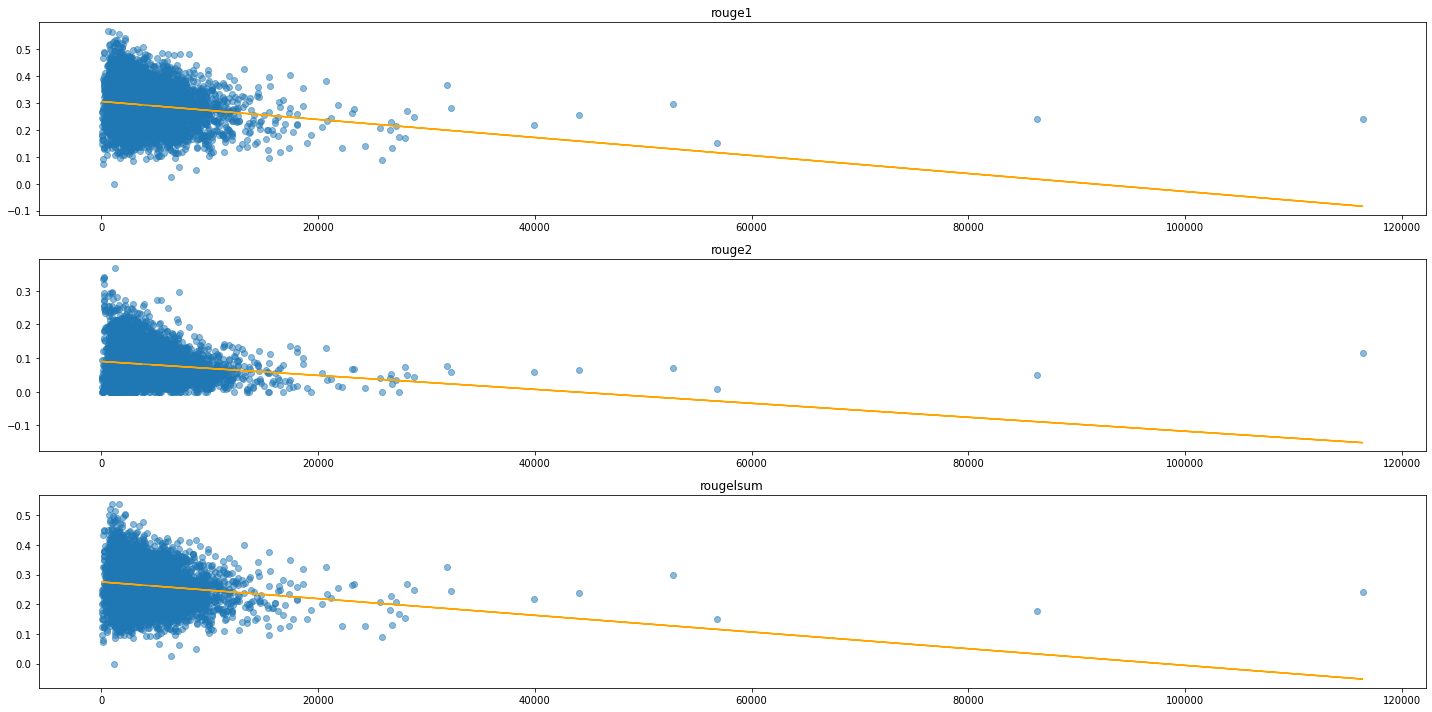

In [30]:
df = pubmed_results_df
fig, axs = plt.subplots(3,1, figsize = (20,10))
axs[0].set_title('rouge1')
axs[0].scatter(df.doc_len, df.r1, alpha=0.5)
m1, b1 = np.polyfit(df.doc_len, df.r1, 1)
axs[0].plot(df.doc_len, m1*df.doc_len + b1, c='orange')

# rouge 2
axs[1].set_title('rouge2')
axs[1].scatter(df.doc_len, df.r2, alpha=0.5)
m4, b4 = np.polyfit(df.doc_len, df.r2, 1)
axs[1].plot(df.doc_len, m4*df.doc_len + b4, c='orange')

# rouge lsum
axs[2].set_title('rougelsum')
axs[2].scatter(df.doc_len, df.rlsum, alpha=0.5)
m7, b7 = np.polyfit(df.doc_len, df.rlsum, 1)
axs[2].plot(df.doc_len, m7*df.doc_len + b7, c='orange')
plt.tight_layout()

print(f'r1 coefficient: {m1}')
print(f'r2 coefficient: {m4}')
print(f'rlsum coefficient: {m7}')
print('')
print(f'r1 Mean: {df.r1.mean()}')
print(f'r2 Mean: {df.r2.mean()}')
print(f'rlsum Mean: {df.rlsum.mean()}')

r1 coefficient: -3.217841362994783e-06
r2 coefficient: -1.5506416075592131e-06
rlsum coefficient: -2.0699465054132033e-06

r1 Mean: 0.28433597559095664
r2 Mean: 0.0802748513824897
rlsum Mean: 0.19565481648086253


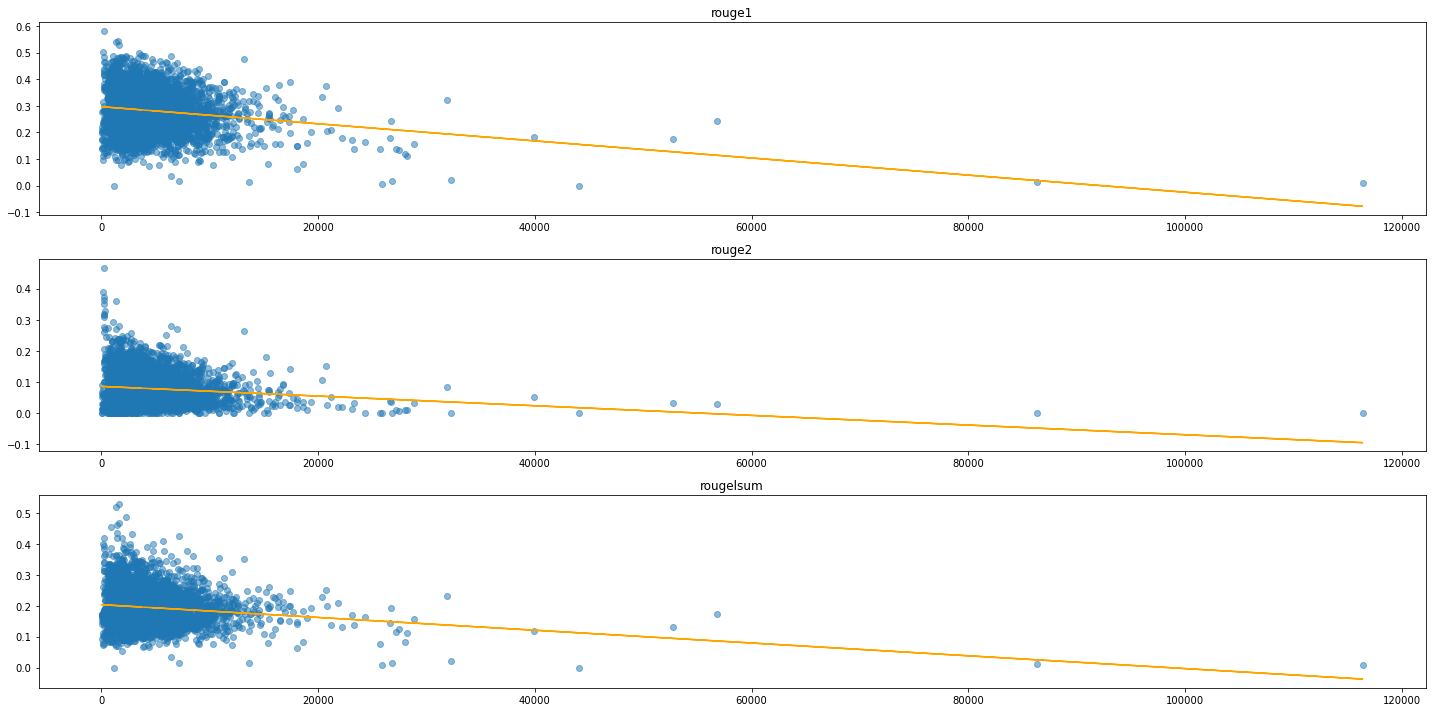

In [31]:
df = ranked_pubmed_results_df
fig, axs = plt.subplots(3,1, figsize = (20,10))
axs[0].set_title('rouge1')
axs[0].scatter(df.doc_len, df.r1, alpha=0.5)
m1, b1 = np.polyfit(df.doc_len, df.r1, 1)
axs[0].plot(df.doc_len, m1*df.doc_len + b1, c='orange')

# rouge 2
axs[1].set_title('rouge2')
axs[1].scatter(df.doc_len, df.r2, alpha=0.5)
m4, b4 = np.polyfit(df.doc_len, df.r2, 1)
axs[1].plot(df.doc_len, m4*df.doc_len + b4, c='orange')

# rouge lsum
axs[2].set_title('rougelsum')
axs[2].scatter(df.doc_len, df.rlsum, alpha=0.5)
m7, b7 = np.polyfit(df.doc_len, df.rlsum, 1)
axs[2].plot(df.doc_len, m7*df.doc_len + b7, c='orange')
plt.tight_layout()

print(f'r1 coefficient: {m1}')
print(f'r2 coefficient: {m4}')
print(f'rlsum coefficient: {m7}')
print('')
print(f'r1 Mean: {df.r1.mean()}')
print(f'r2 Mean: {df.r2.mean()}')
print(f'rlsum Mean: {df.rlsum.mean()}')

r1 coefficient: -4.066218007506686e-06
r2 coefficient: -2.018004010041519e-06
rlsum coefficient: -2.6201919467038705e-06

r1 Mean: 0.2846611109149974
r2 Mean: 0.07979153020870702
rlsum Mean: 0.19519681332145444


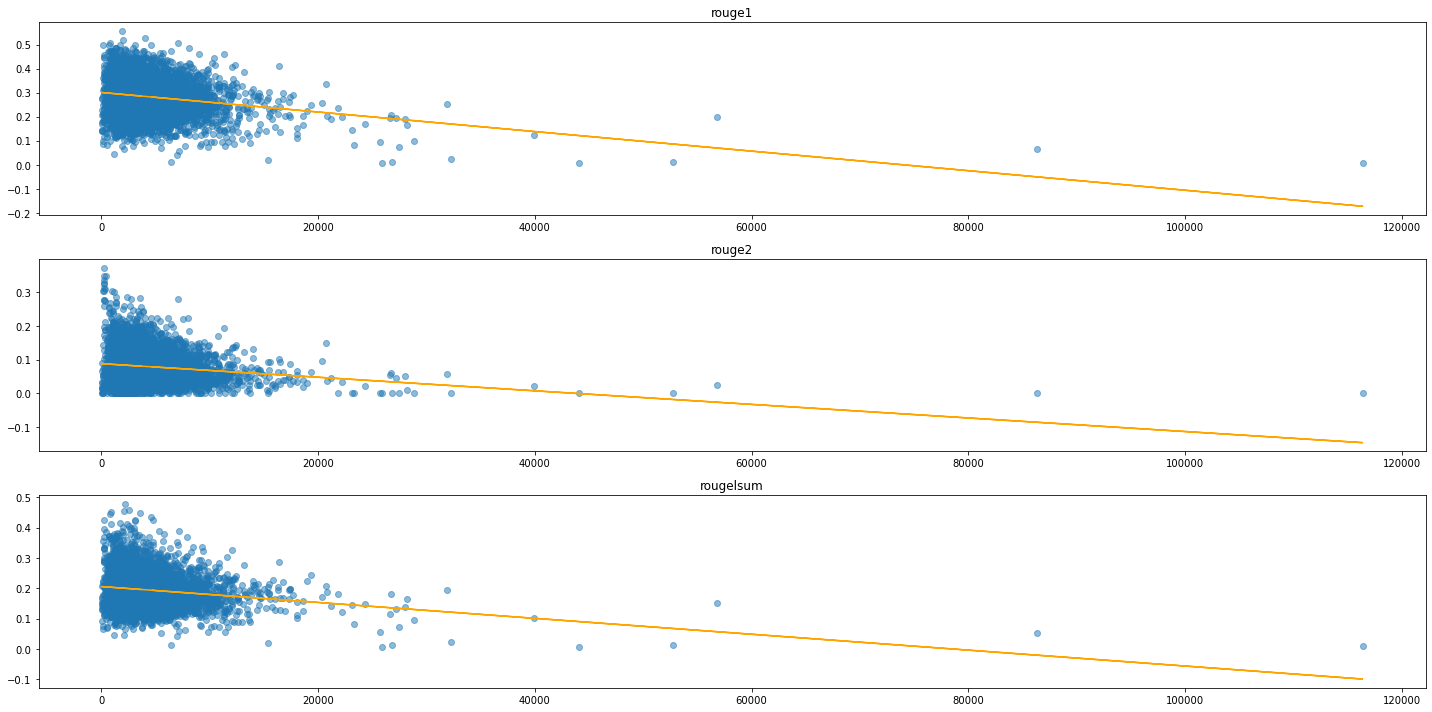

In [32]:
df = ranked_temporal_pubmed_results_df
fig, axs = plt.subplots(3,1, figsize = (20,10))
axs[0].set_title('rouge1')
axs[0].scatter(df.doc_len, df.r1, alpha=0.5)
m1, b1 = np.polyfit(df.doc_len, df.r1, 1)
axs[0].plot(df.doc_len, m1*df.doc_len + b1, c='orange')

# rouge 2
axs[1].set_title('rouge2')
axs[1].scatter(df.doc_len, df.r2, alpha=0.5)
m4, b4 = np.polyfit(df.doc_len, df.r2, 1)
axs[1].plot(df.doc_len, m4*df.doc_len + b4, c='orange')

# rouge lsum
axs[2].set_title('rougelsum')
axs[2].scatter(df.doc_len, df.rlsum, alpha=0.5)
m7, b7 = np.polyfit(df.doc_len, df.rlsum, 1)
axs[2].plot(df.doc_len, m7*df.doc_len + b7, c='orange')
plt.tight_layout()

print(f'r1 coefficient: {m1}')
print(f'r2 coefficient: {m4}')
print(f'rlsum coefficient: {m7}')
print('')
print(f'r1 Mean: {df.r1.mean()}')
print(f'r2 Mean: {df.r2.mean()}')
print(f'rlsum Mean: {df.rlsum.mean()}')

# Long Documents (> 4096 tokens)

r1 coefficient: -2.1182221656433556e-06
r2 coefficient: -1.1490248525744964e-06
rlsum coefficient: -1.7041933943419551e-06

r1 Mean: 0.2776900621641823
r2 Mean: 0.07211755638988462
rlsum Mean: 0.2512577555402491


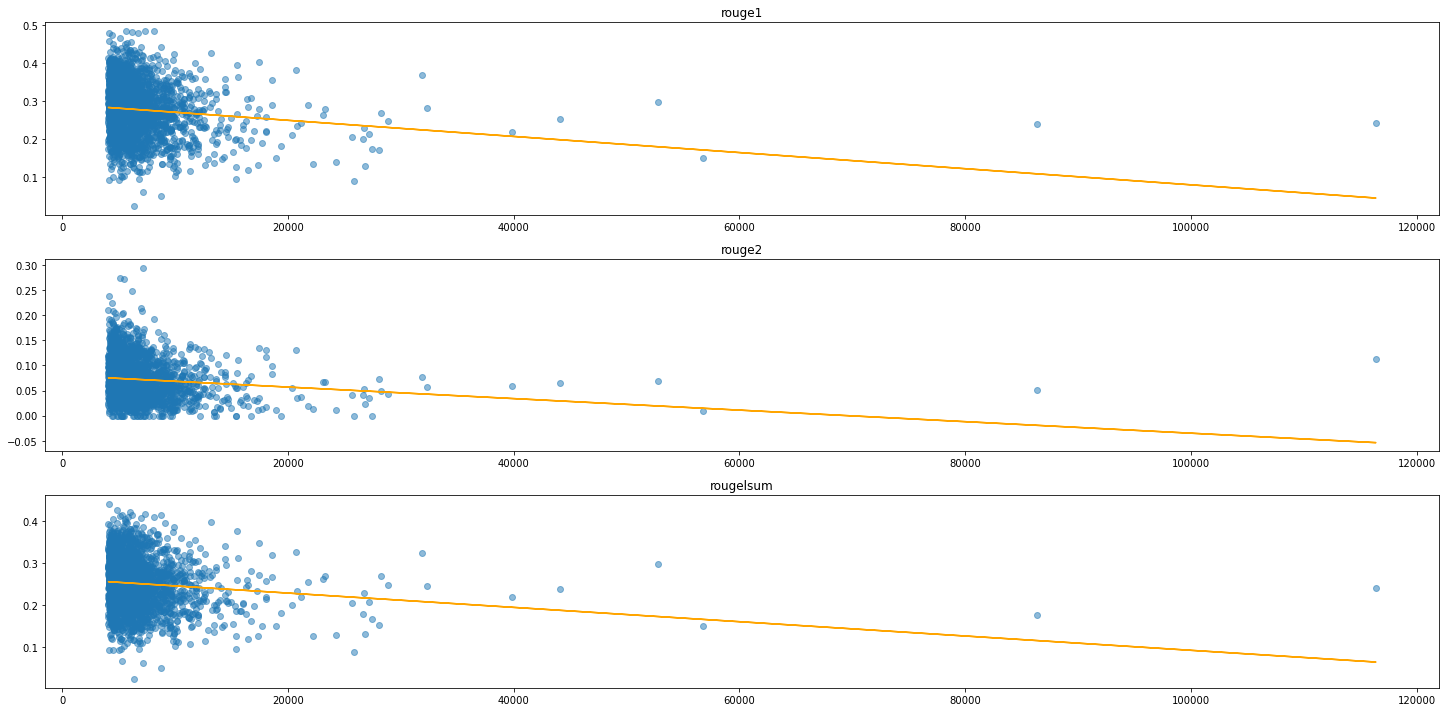

In [33]:
df = pubmed_results_df
df = df[df['doc_len'] > 4096]
fig, axs = plt.subplots(3,1, figsize = (20,10))
axs[0].set_title('rouge1')
axs[0].scatter(df.doc_len, df.r1, alpha=0.5)
m1, b1 = np.polyfit(df.doc_len, df.r1, 1)
axs[0].plot(df.doc_len, m1*df.doc_len + b1, c='orange')

# rouge 2
axs[1].set_title('rouge2')
axs[1].scatter(df.doc_len, df.r2, alpha=0.5)
m4, b4 = np.polyfit(df.doc_len, df.r2, 1)
axs[1].plot(df.doc_len, m4*df.doc_len + b4, c='orange')

# rouge lsum
axs[2].set_title('rougelsum')
axs[2].scatter(df.doc_len, df.rlsum, alpha=0.5)
m7, b7 = np.polyfit(df.doc_len, df.rlsum, 1)
axs[2].plot(df.doc_len, m7*df.doc_len + b7, c='orange')
plt.tight_layout()

print(f'r1 coefficient: {m1}')
print(f'r2 coefficient: {m4}')
print(f'rlsum coefficient: {m7}')
print('')
print(f'r1 Mean: {df.r1.mean()}')
print(f'r2 Mean: {df.r2.mean()}')
print(f'rlsum Mean: {df.rlsum.mean()}')

r1 coefficient: -3.791436320804745e-06
r2 coefficient: -1.7158752497009844e-06
rlsum coefficient: -2.0643693452693596e-06

r1 Mean: 0.2768546257485501
r2 Mean: 0.07620420257718451
rlsum Mean: 0.18992826154110093


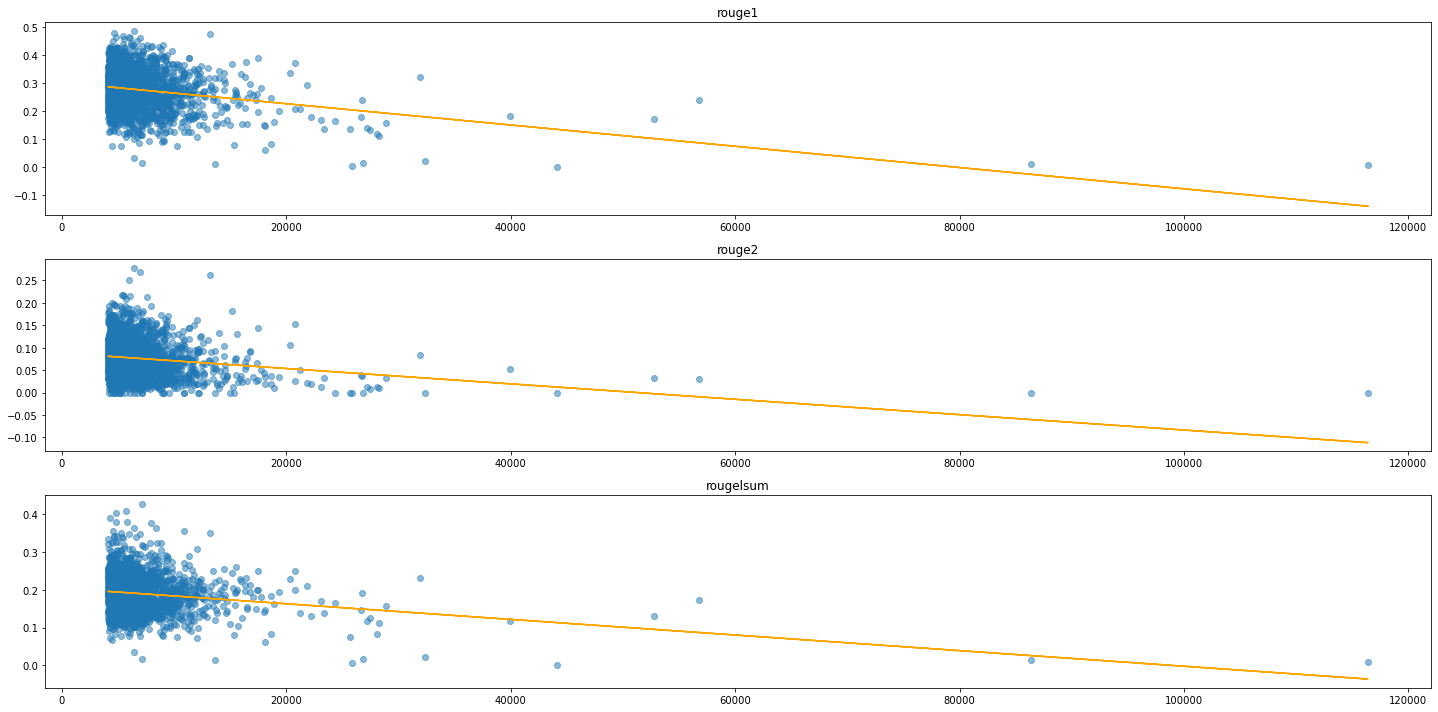

In [34]:
df = ranked_pubmed_results_df
df = df[df['doc_len'] > 4096]
fig, axs = plt.subplots(3,1, figsize = (20,10))
axs[0].set_title('rouge1')
axs[0].scatter(df.doc_len, df.r1, alpha=0.5)
m1, b1 = np.polyfit(df.doc_len, df.r1, 1)
axs[0].plot(df.doc_len, m1*df.doc_len + b1, c='orange')

# rouge 2
axs[1].set_title('rouge2')
axs[1].scatter(df.doc_len, df.r2, alpha=0.5)
m4, b4 = np.polyfit(df.doc_len, df.r2, 1)
axs[1].plot(df.doc_len, m4*df.doc_len + b4, c='orange')

# rouge lsum
axs[2].set_title('rougelsum')
axs[2].scatter(df.doc_len, df.rlsum, alpha=0.5)
m7, b7 = np.polyfit(df.doc_len, df.rlsum, 1)
axs[2].plot(df.doc_len, m7*df.doc_len + b7, c='orange')
plt.tight_layout()

print(f'r1 coefficient: {m1}')
print(f'r2 coefficient: {m4}')
print(f'rlsum coefficient: {m7}')
print('')
print(f'r1 Mean: {df.r1.mean()}')
print(f'r2 Mean: {df.r2.mean()}')
print(f'rlsum Mean: {df.rlsum.mean()}')

r1 coefficient: -4.140588585915981e-06
r2 coefficient: -1.7346488839816935e-06
rlsum coefficient: -2.2403296166451056e-06

r1 Mean: 0.2723737880736369
r2 Mean: 0.07218088807423217
rlsum Mean: 0.18629628257480862


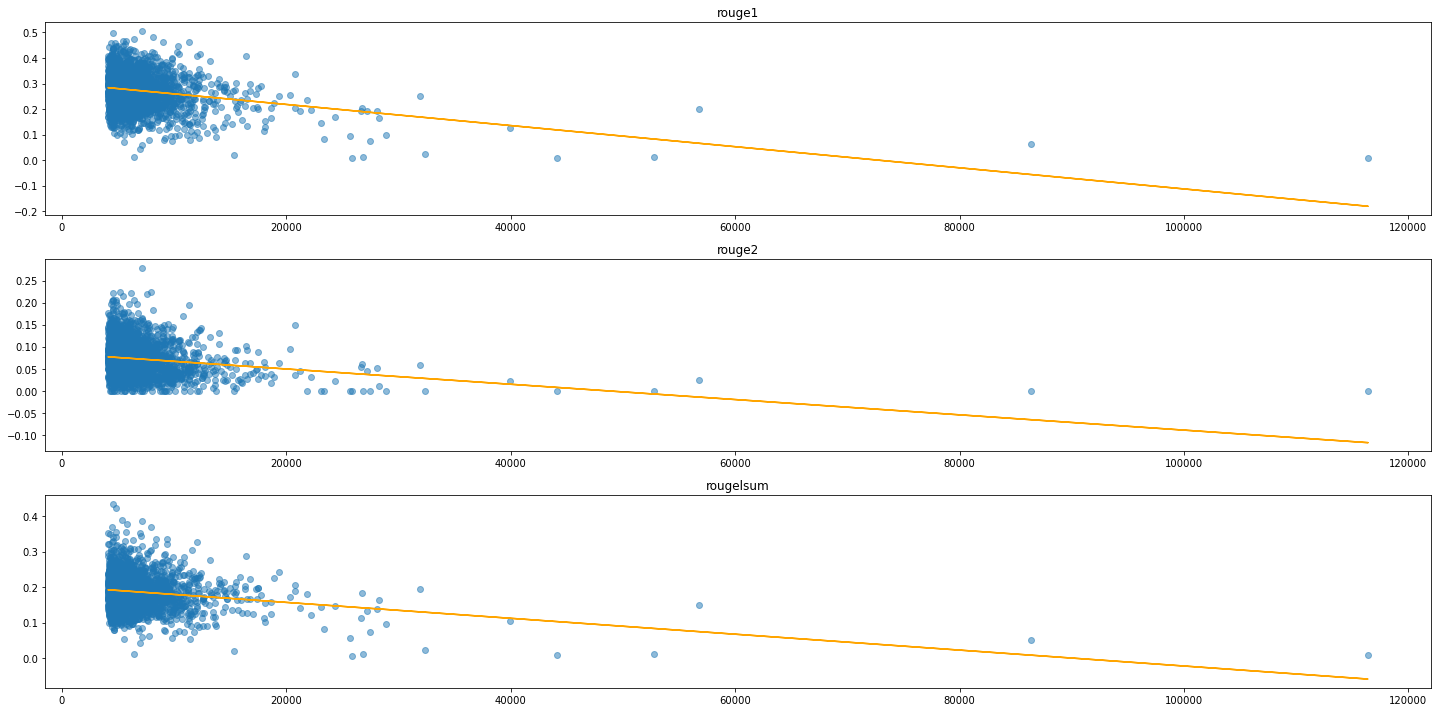

In [35]:
df = ranked_temporal_pubmed_results_df
df = df[df['doc_len'] > 4096]
fig, axs = plt.subplots(3,1, figsize = (20,10))
axs[0].set_title('rouge1')
axs[0].scatter(df.doc_len, df.r1, alpha=0.5)
m1, b1 = np.polyfit(df.doc_len, df.r1, 1)
axs[0].plot(df.doc_len, m1*df.doc_len + b1, c='orange')

# rouge 2
axs[1].set_title('rouge2')
axs[1].scatter(df.doc_len, df.r2, alpha=0.5)
m4, b4 = np.polyfit(df.doc_len, df.r2, 1)
axs[1].plot(df.doc_len, m4*df.doc_len + b4, c='orange')

# rouge lsum
axs[2].set_title('rougelsum')
axs[2].scatter(df.doc_len, df.rlsum, alpha=0.5)
m7, b7 = np.polyfit(df.doc_len, df.rlsum, 1)
axs[2].plot(df.doc_len, m7*df.doc_len + b7, c='orange')
plt.tight_layout()

print(f'r1 coefficient: {m1}')
print(f'r2 coefficient: {m4}')
print(f'rlsum coefficient: {m7}')
print('')
print(f'r1 Mean: {df.r1.mean()}')
print(f'r2 Mean: {df.r2.mean()}')
print(f'rlsum Mean: {df.rlsum.mean()}')

# Short documents (< 4096 tokens)

r1 coefficient: -4.510964539763794e-06
r2 coefficient: -2.855638346973319e-06
rlsum coefficient: -3.6564158974783634e-06

r1 Mean: 0.3004294088352826
r2 Mean: 0.08728198787068918
rlsum Mean: 0.27093705135214224


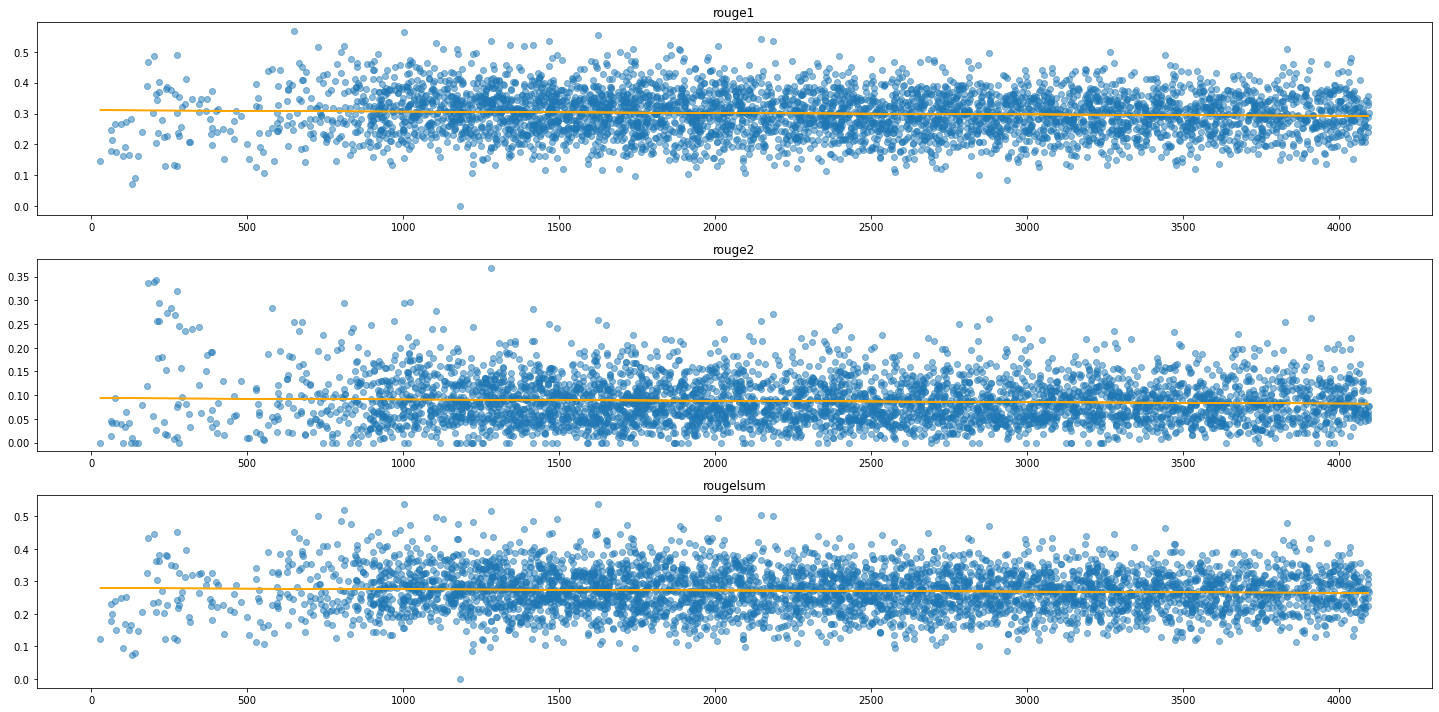

In [36]:
df = pubmed_results_df
df = df[df['doc_len'] < 4096]
fig, axs = plt.subplots(3,1, figsize = (20,10))
axs[0].set_title('rouge1')
axs[0].scatter(df.doc_len, df.r1, alpha=0.5)
m1, b1 = np.polyfit(df.doc_len, df.r1, 1)
axs[0].plot(df.doc_len, m1*df.doc_len + b1, c='orange')

# rouge 2
axs[1].set_title('rouge2')
axs[1].scatter(df.doc_len, df.r2, alpha=0.5)
m4, b4 = np.polyfit(df.doc_len, df.r2, 1)
axs[1].plot(df.doc_len, m4*df.doc_len + b4, c='orange')

# rouge lsum
axs[2].set_title('rougelsum')
axs[2].scatter(df.doc_len, df.rlsum, alpha=0.5)
m7, b7 = np.polyfit(df.doc_len, df.rlsum, 1)
axs[2].plot(df.doc_len, m7*df.doc_len + b7, c='orange')
plt.tight_layout()

print(f'r1 coefficient: {m1}')
print(f'r2 coefficient: {m4}')
print(f'rlsum coefficient: {m7}')
print('')
print(f'r1 Mean: {df.r1.mean()}')
print(f'r2 Mean: {df.r2.mean()}')
print(f'rlsum Mean: {df.rlsum.mean()}')

r1 coefficient: -1.8465513031914143e-06
r2 coefficient: -9.6288755686442e-07
rlsum coefficient: -3.103523791899564e-06

r1 Mean: 0.28837561431166386
r2 Mean: 0.08246391233195541
rlsum Mean: 0.198756585298326


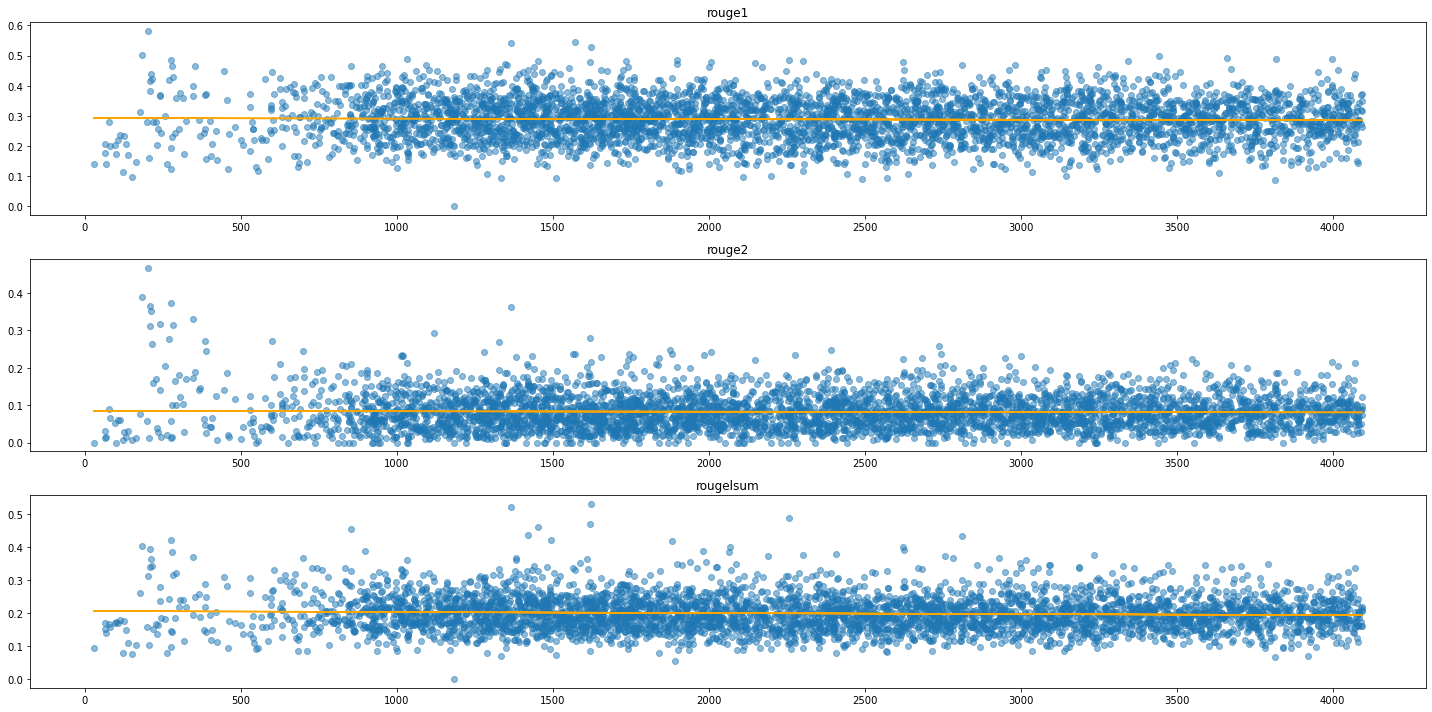

In [37]:
df = ranked_pubmed_results_df
df = df[df['doc_len'] < 4096]
fig, axs = plt.subplots(3,1, figsize = (20,10))
axs[0].set_title('rouge1')
axs[0].scatter(df.doc_len, df.r1, alpha=0.5)
m1, b1 = np.polyfit(df.doc_len, df.r1, 1)
axs[0].plot(df.doc_len, m1*df.doc_len + b1, c='orange')

# rouge 2
axs[1].set_title('rouge2')
axs[1].scatter(df.doc_len, df.r2, alpha=0.5)
m4, b4 = np.polyfit(df.doc_len, df.r2, 1)
axs[1].plot(df.doc_len, m4*df.doc_len + b4, c='orange')

# rouge lsum
axs[2].set_title('rougelsum')
axs[2].scatter(df.doc_len, df.rlsum, alpha=0.5)
m7, b7 = np.polyfit(df.doc_len, df.rlsum, 1)
axs[2].plot(df.doc_len, m7*df.doc_len + b7, c='orange')
plt.tight_layout()

print(f'r1 coefficient: {m1}')
print(f'r2 coefficient: {m4}')
print(f'rlsum coefficient: {m7}')
print('')
print(f'r1 Mean: {df.r1.mean()}')
print(f'r2 Mean: {df.r2.mean()}')
print(f'rlsum Mean: {df.rlsum.mean()}')

r1 coefficient: -2.2971292335452402e-06
r2 coefficient: -8.29950907764952e-07
rlsum coefficient: -3.839691375117249e-06

r1 Mean: 0.2913312717855546
r2 Mean: 0.08392499980254661
rlsum Mean: 0.20003227407399937


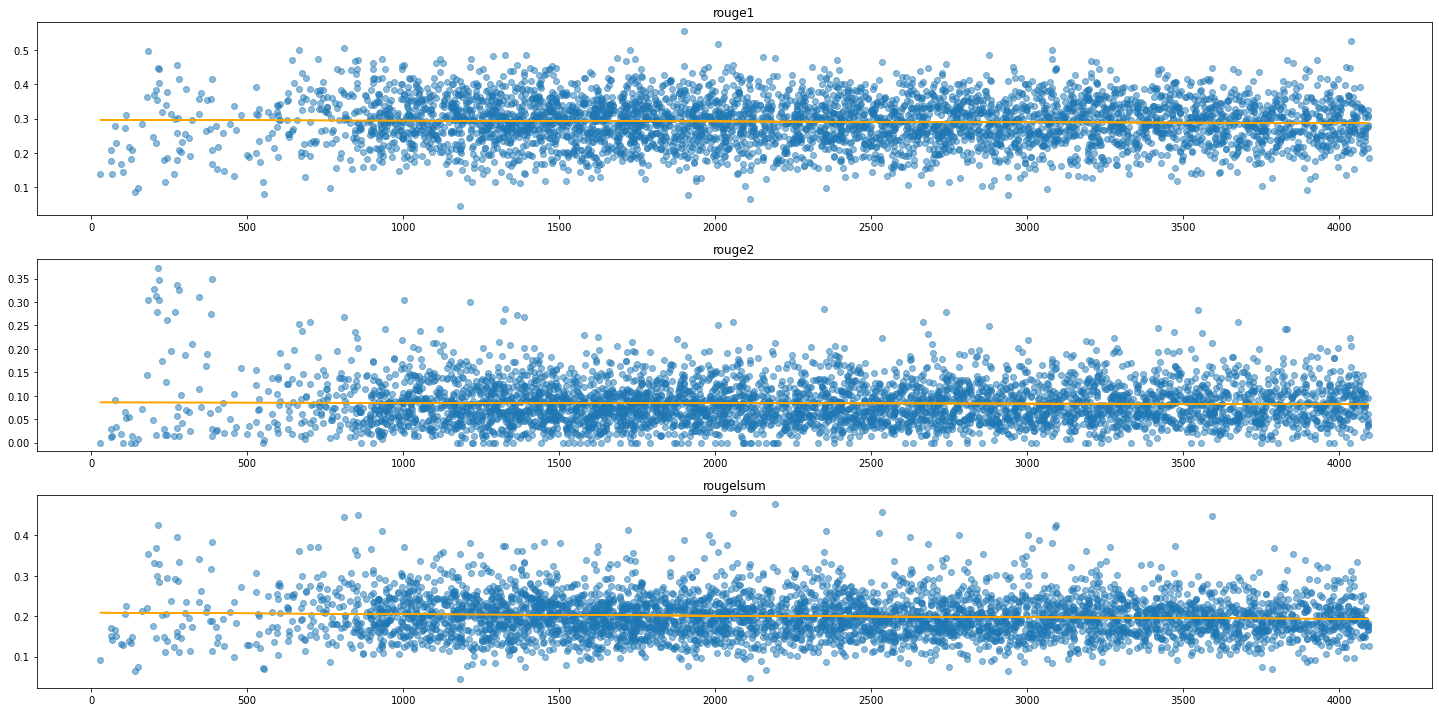

In [38]:
df = ranked_temporal_pubmed_results_df
df = df[df['doc_len'] < 4096]
fig, axs = plt.subplots(3,1, figsize = (20,10))
axs[0].set_title('rouge1')
axs[0].scatter(df.doc_len, df.r1, alpha=0.5)
m1, b1 = np.polyfit(df.doc_len, df.r1, 1)
axs[0].plot(df.doc_len, m1*df.doc_len + b1, c='orange')

# rouge 2
axs[1].set_title('rouge2')
axs[1].scatter(df.doc_len, df.r2, alpha=0.5)
m4, b4 = np.polyfit(df.doc_len, df.r2, 1)
axs[1].plot(df.doc_len, m4*df.doc_len + b4, c='orange')

# rouge lsum
axs[2].set_title('rougelsum')
axs[2].scatter(df.doc_len, df.rlsum, alpha=0.5)
m7, b7 = np.polyfit(df.doc_len, df.rlsum, 1)
axs[2].plot(df.doc_len, m7*df.doc_len + b7, c='orange')
plt.tight_layout()

print(f'r1 coefficient: {m1}')
print(f'r2 coefficient: {m4}')
print(f'rlsum coefficient: {m7}')
print('')
print(f'r1 Mean: {df.r1.mean()}')
print(f'r2 Mean: {df.r2.mean()}')
print(f'rlsum Mean: {df.rlsum.mean()}')